In [21]:
import os
import pickle
import pandas as pd


from sklearn.pipeline import Pipeline


from xgboost import XGBRegressor


import numpy as np


import warnings
import pandas as pd



from feature_engine.encoding import OneHotEncoder


from feature_engine.imputation import (
    ArbitraryNumberImputer,
    CategoricalImputer,
)


from feature_engine.selection import DropConstantFeatures


from sklearn.pipeline import Pipeline


from xgboost import XGBRegressor


from sktime.transformations.series.summarize import WindowSummarizer
import datetime



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



import seaborn as sns



from sklearn import set_config


from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.metrics import mean_absolute_percentage_error as mape



set_config(transform_output="pandas")


sns.set_context("talk")


warnings.filterwarnings("ignore", category=DeprecationWarning)

In [22]:
CATEGORICAL_COLUMNS = ["holiday_name"]
NUMERICAL_COLUMNS = [
    "holiday",
    "shutdown",
    "mini_shutdown",
    "shops_closed",
    "winter_school_holidays",
    "school_holidays",
    "blackout",
    "mov_change",
    "frankfurt_shutdown",
    "year",
    "month",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "weekend",
]
DATE_COLUMNS = ["date"]

TARGET_COLUMNS = "orders"
FEATRURE_COLUMNS = NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS  # + DATE_COLUMNS
TRAIN_LEVEL = ["warehouse"]
MODEL_PATH = "model_registry"

# Functions


In [23]:
pipeline = Pipeline(
    [
        # ('drop_na_lags', DropMissingData(variables=new_cols)),
        # Impute missing categorical except mean-encoded ones, normally happens in the test data
        (
            "missing_categoricals",
            CategoricalImputer(
                imputation_method="missing", variables=CATEGORICAL_COLUMNS
            ),
        ),
        # Impute 0 for missing numericals
        (
            "missing_numerical",
            ArbitraryNumberImputer(variables=NUMERICAL_COLUMNS, arbitrary_number=0),
        ),
        # OneHotEncode the rest of categorical
        (
            "onehot_encoding",
            OneHotEncoder(
                top_categories=6,
                variables=CATEGORICAL_COLUMNS,
                ignore_format=True,
            ),
        ),
        # Drop Constant features
        ("drop_constant", DropConstantFeatures(tol=1)),
        (
            "xgb",
            XGBRegressor(
                # learning_rate=0.05,
                # n_estimators=100,
                # max_depth=6,
                # subsample=0.8,
                # colsample_bytree=0.8,
                # alpha=0.5,
                # # lambda=1,
                # min_child_weight=5,
                # gamma=0,
            ),
        ),
    ]
)

In [24]:
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 7, 365],  # Lag features.
        "mean": [[1, 7], [365, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    # truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [25]:
lag_window_feats_2 = WindowSummarizer(
    lag_feature={
        "lag": [1, 7],  # Lag features.
        "mean": [[1, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    # truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [26]:
lag_window_feats_3 = WindowSummarizer(
    lag_feature={
        "lag": [1, 7, 365],  # Lag features.
        "mean": [[1, 7], [365, 7]],  # [[lag, window size]]
    },
    target_cols="y",
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

In [27]:
def train_predict_sktime(
    df,
    feature_columns,
    target_columns,
    max_lag=365,
    pipeline=None,
    pipeline_lags_transformer=None,
    imputation="mean",
):

    print(f"warehouse: {df.warehouse.unique()[0]}")

    df.rename(columns={target_columns: "y"}, inplace=True)

    df_train = df.query("split=='train'")[feature_columns + ["y", "missing"]].copy()
    df_test = df.query("split=='test'")[feature_columns + ["y", "missing"]].copy()
    df_predict = df[
        (df.split == "test")
        | (
            (df.split == "train")
            & (df.index < (df_train.index.max() - datetime.timedelta(days=max_lag)))
        )
    ]
    if imputation == "mean":
        df_train["y"] = np.where(
            df_train["missing"] == 1, df_train["y"].mean(), df_train["y"]
        )
    elif imputation == "zero":
        df_train["y"] = np.where(df_train["missing"] == 1, 0, df_train["y"])
    else:
        raise ValueError("Imputation method not supported")

    # print(
    #     "Shape of df_train and df_test before lag transformation",
    #     df_train.shape,
    #     df_test.shape,
    # )

    df_train_lags_only = pipeline_lags_transformer.fit_transform(df_train[["y"]])

    # print("Shape of df_train  only for lags", df_train_lags_only.shape)

    new_cols = list(df_train_lags_only.columns)

    df_train_lags = pd.concat([df_train, df_train_lags_only], axis=1)
    # drop missing targets
    df_train_lags = df_train_lags.query("missing == 0")

    # print("Shape of df_train after lag transformation", df_train_lags.shape)
    df_train_lags.dropna(subset=new_cols, how="any", inplace=True)
    # print("Shape of df_train after droping the nulls", df_train_lags.shape)

    X_train = df_train_lags[feature_columns + new_cols]
    y_train = df_train_lags["y"]

    model = pipeline.fit(X_train, y_train)

    for forecast_time in df_test.index:
        df_predict_lags_only = pipeline_lags_transformer.transform(df_predict[["y"]])
        X_test = pd.concat([df_predict, df_predict_lags_only], axis=1)
        X_test_ = X_test.loc[[forecast_time]]
        y_pred = model.predict(X_test_[feature_columns + new_cols])
        df_predict.loc[[forecast_time], "y"] = y_pred

    df_predict.rename(columns={"y": target_columns}, inplace=True)

    return df_predict.query("split=='test' and missing==0")

In [28]:
def load_data():
    PATH = "./data/"
    df_train = pd.read_csv(
        f"{PATH}train_new.csv", parse_dates=["date"], index_col="date"
    )
    df_train["split"] = "train"

    df_test = pd.read_csv(f"{PATH}test_new.csv", parse_dates=["date"], index_col="date")
    df_test["split"] = "test"

    cols = df_train.columns
    df_test = df_test[cols]

    df = pd.concat([df_train, df_test], axis=0)

    return df

In [29]:
def load_test_data(test_days=90):
    PATH = "./data/"
    df_train = pd.read_csv(
        f"{PATH}train_new.csv", parse_dates=["date"], index_col="date"
    )
    df_train["orders_copy"] = df_train["orders"]

    max_date = df_train.index.max() - datetime.timedelta(days=test_days)
    df_train.loc[df_train.index > max_date, "split"] = "test"
    df_train.loc[df_train.index <= max_date, "split"] = "train"
    df_train["orders"] = np.where(
        df_train["split"] == "test", np.nan, df_train["orders"]
    )

    return df_train


def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

# run the code


In [30]:
# load the data
# df = load_data()
df = load_test_data(test_days=90)

In [31]:
df_forecast = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,

        pipeline_lags_transformer=lag_window_feats,
        imputation="mean",

    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [32]:
df_forecast_2 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=7,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_2,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [33]:
df_forecast_3 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_3,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


# Batch training without lags


In [34]:
def train_model_core(
    df: pd.DataFrame,
    train_level: list,
    feature_columns: list,
    target_column: str,
    pipeline: Pipeline,
    model_dir: str = "model_registry",
) -> pd.DataFrame:
    """This function run the train for a single level.

    Args:
        df (pd.DataFrame): A dataframe including level columns, features, and target columns
        train_level (list): training level i.e. `['warehouse', 'item_class']`
        feature_columns (list): Feature columns.
        target_column (str): traget columns should be a single string.
        model_dir (str, optional): Name of the directory for saving the model pickel files. Defaults to "model_registry".

    Returns:
        pd.DataFrame: A single row dataframe including the train level, model registry path, and error if we have any.
    """

    e = ""
    train_level_value = df[train_level].iloc[0, :].to_list()

    try:
        X = df[feature_columns]
        y = df[target_column]

        model = pipeline.fit(X, y)

        # saving the model to model registry
        os.makedirs(model_dir, exist_ok=True)
        model_string = "_".join(
            [f"{a}_{b}" for a, b in zip(train_level, train_level_value)]
        )
        model_path = os.path.join(model_dir, f"model_{model_string}.pkl")
        with open(model_path, "wb") as f:
            pickle.dump(model, f)

    except Exception as e:
        print("e")

    train_df = pd.DataFrame(
        [train_level_value + ["_".join(train_level)] + [model_path] + [e]],
        columns=[*train_level, "train_level", "model_path", "error"],
    )

    return train_df

In [35]:
def score_model_core(
    df: pd.DataFrame,
    train_level: list,
    feature_columns: list,
    target_column: str,
    model_dir: str = "model_registry",
) -> pd.DataFrame:
    """Loading a model from model registry and inference.

    Args:
        df (pd.DataFrame): A dataframe including level columns, features, and target columns
        train_level (list): training level i.e. `['warehouse', 'item_class']`
        feature_columns (list): Feature columns.
        target_column (str): traget columns should be a single string.
        model_dir (str, optional): Name of the directory for saving the model pickel files. Defaults to "model_registry".

    Returns:
        pd.DataFrame: A dataframe including all input dataframe with forecast and error column added at the end.
    """
    e = ""
    df = df.copy()
    train_level_value = df[train_level].iloc[0, :].to_list()

    try:
        X = df[feature_columns]
        y = df[target_column]

        model_string = "_".join(
            [f"{a}_{b}" for a, b in zip(train_level, train_level_value)]
        )
        model_path = os.path.join(model_dir, f"model_{model_string}.pkl")
        with open(model_path, "rb") as f:
            model = pickle.load(f)

        df.loc[:, "forecast"] = model.predict(X)
        df.loc[:, "model_path"] = model_path

    except Exception as e:
        df.loc[:, "forecast"] = np.null
        df.loc[:, "model_path"] = np.null

    df.loc[:, "error"] = e
    return df

In [36]:
df.query(f"split=='train' and not {TARGET_COLUMNS}.isnull()").groupby(
    TRAIN_LEVEL
).apply(
    train_model_core,
    TRAIN_LEVEL,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    pipeline,
    model_dir=MODEL_PATH,
    include_groups=True,
).reset_index(
    drop=True
)

,warehouse,train_level,model_path,error
0,Brno_1,warehouse,model_registry\model_warehouse_Brno_1.pkl,
1,Budapest_1,warehouse,model_registry\model_warehouse_Budapest_1.pkl,
2,Frankfurt_1,warehouse,model_registry\model_warehouse_Frankfurt_1.pkl,
3,Munich_1,warehouse,model_registry\model_warehouse_Munich_1.pkl,
4,Prague_1,warehouse,model_registry\model_warehouse_Prague_1.pkl,
5,Prague_2,warehouse,model_registry\model_warehouse_Prague_2.pkl,
6,Prague_3,warehouse,model_registry\model_warehouse_Prague_3.pkl,


In [37]:
df_forecast_4 = (
    df.query(f"split=='test'")
    .reset_index()
    .groupby(TRAIN_LEVEL)
    .apply(
        score_model_core,
        TRAIN_LEVEL,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        model_dir=MODEL_PATH,
        include_groups=True,
    )
    .reset_index(drop=True)
    .query("missing==0")
)

# Wmape for all forecast for test dataset


In [63]:
df_final = (
    df_forecast[["id", "warehouse", "date", "orders", "orders_copy"]]
    .merge(
        df_forecast_2[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_2"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_3[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_3"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_4[["id", "warehouse", "date", "forecast"]],
        on=["id", "warehouse", "date"],
        how="left",
    )
)
df_final['ensemble'] = df_final[['orders', 'orders_2', 'orders_3', 'forecast']].mean(axis=1)
df_final['ensemble_2'] = df_final[['orders', 'orders_3']].mean(axis=1)

In [65]:
print(wmape(df_forecast["orders_copy"], df_forecast["orders"]))
print(wmape(df_forecast_2["orders_copy"], df_forecast_2["orders"]))
print(wmape(df_forecast_3["orders_copy"], df_forecast_3["orders"]))
print(wmape(df_forecast_4["orders_copy"], df_forecast_4["forecast"]))
print(wmape(df_final["orders_copy"], df_final["ensemble"]))
print(wmape(df_final["orders_copy"], df_final["ensemble_2"]))

0.09256254063994111
0.13398309258133165
0.10730844013462582
0.14744718529690384
0.11456388895161665
0.0969605715278836


In [66]:
print(mape(df_forecast["orders_copy"], df_forecast["orders"]))
print(mape(df_forecast_2["orders_copy"], df_forecast_2["orders"]))
print(mape(df_forecast_3["orders_copy"], df_forecast_3["orders"]))
print(mape(df_forecast_4["orders_copy"], df_forecast_4["forecast"]))
print(mape(df_final["orders_copy"], df_final["ensemble"]))
print(mape(df_final["orders_copy"], df_final["ensemble_2"]))

# 0.09805396784999384
# 0.136761847065319
# 0.09200489504176833
# 0.1598731638948882

0.09558887463232758
0.13470330334951944
0.1116159176617889
0.15063469190049097
0.11779695879421113
0.10097199352879181


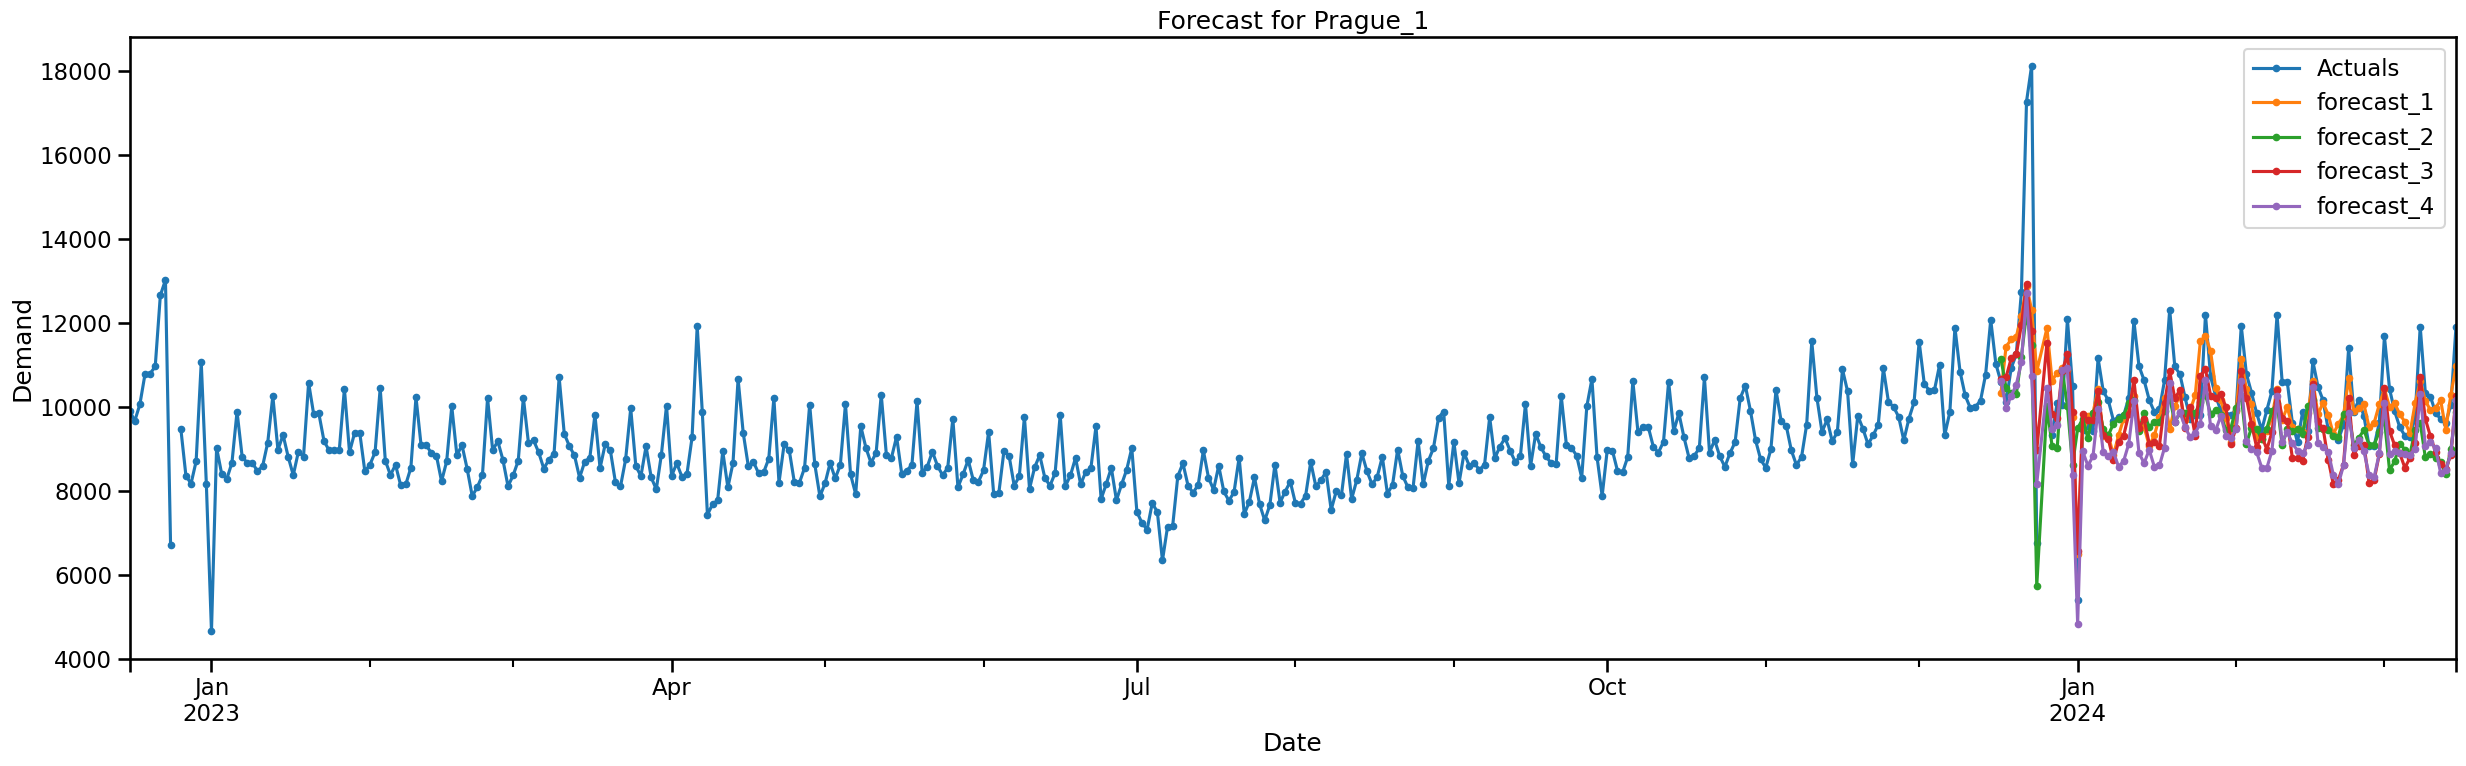

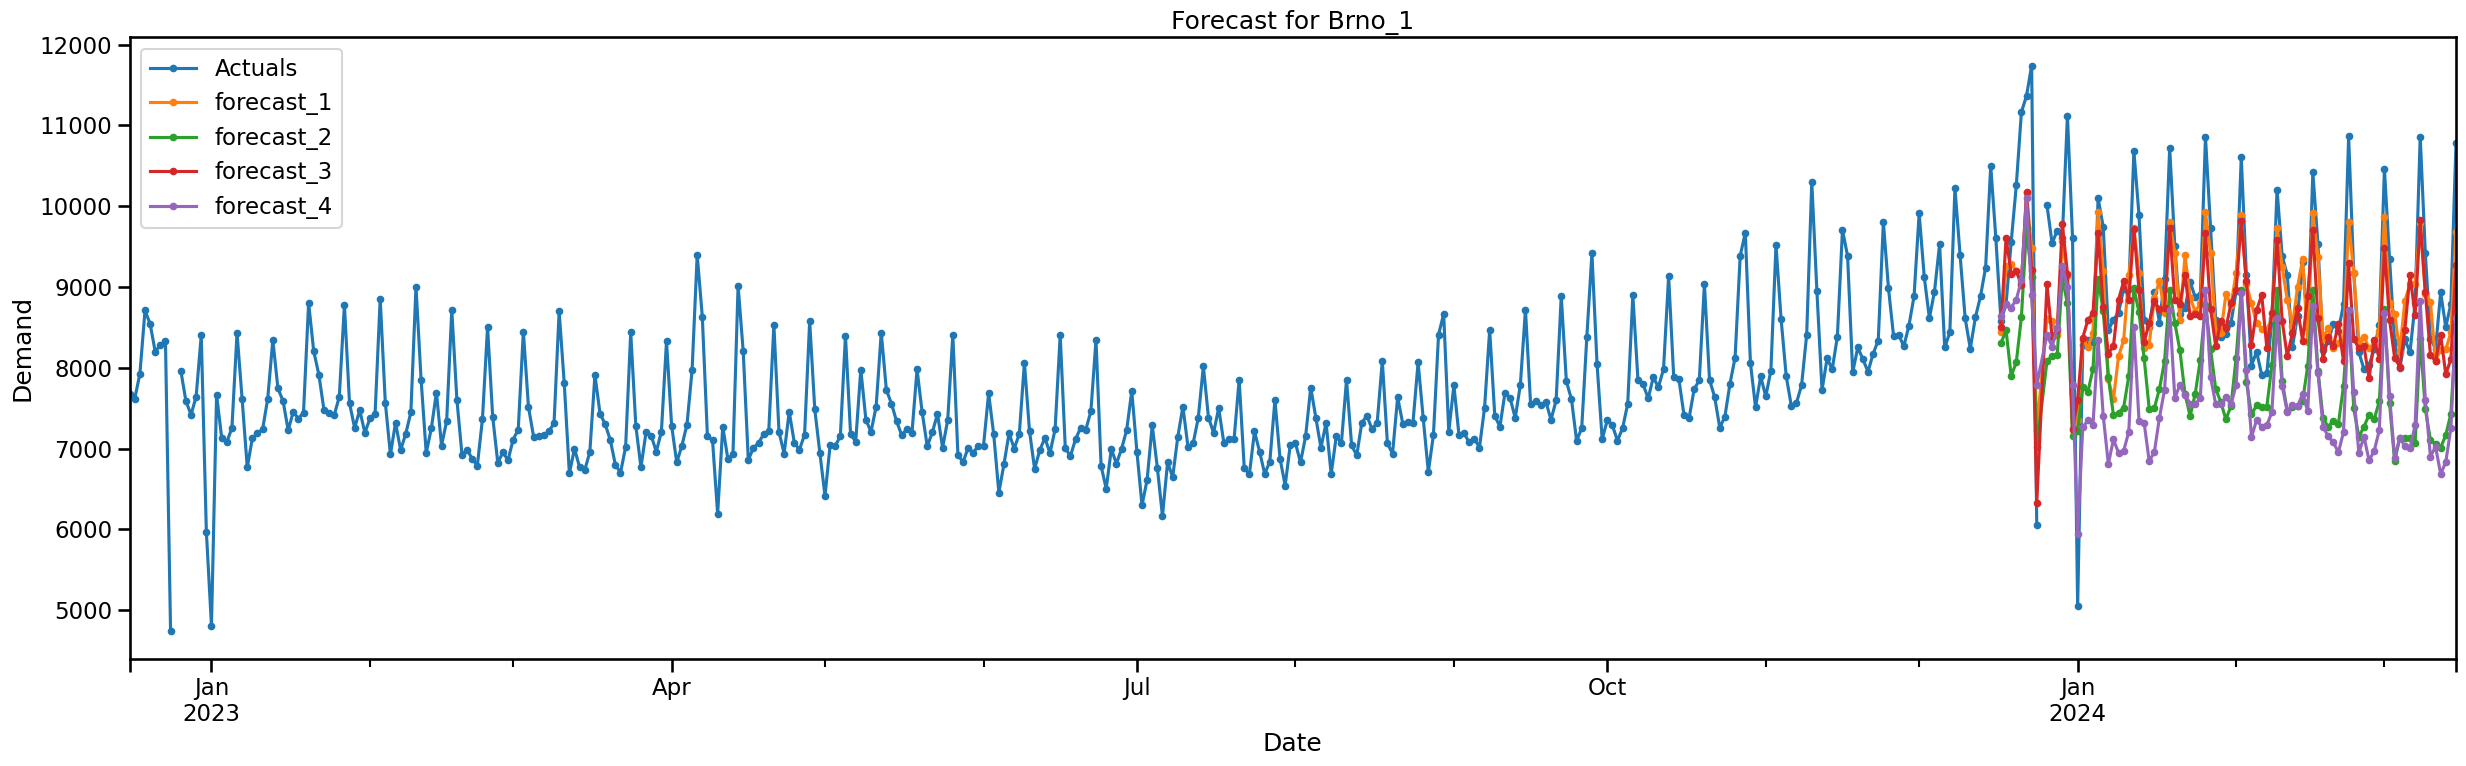

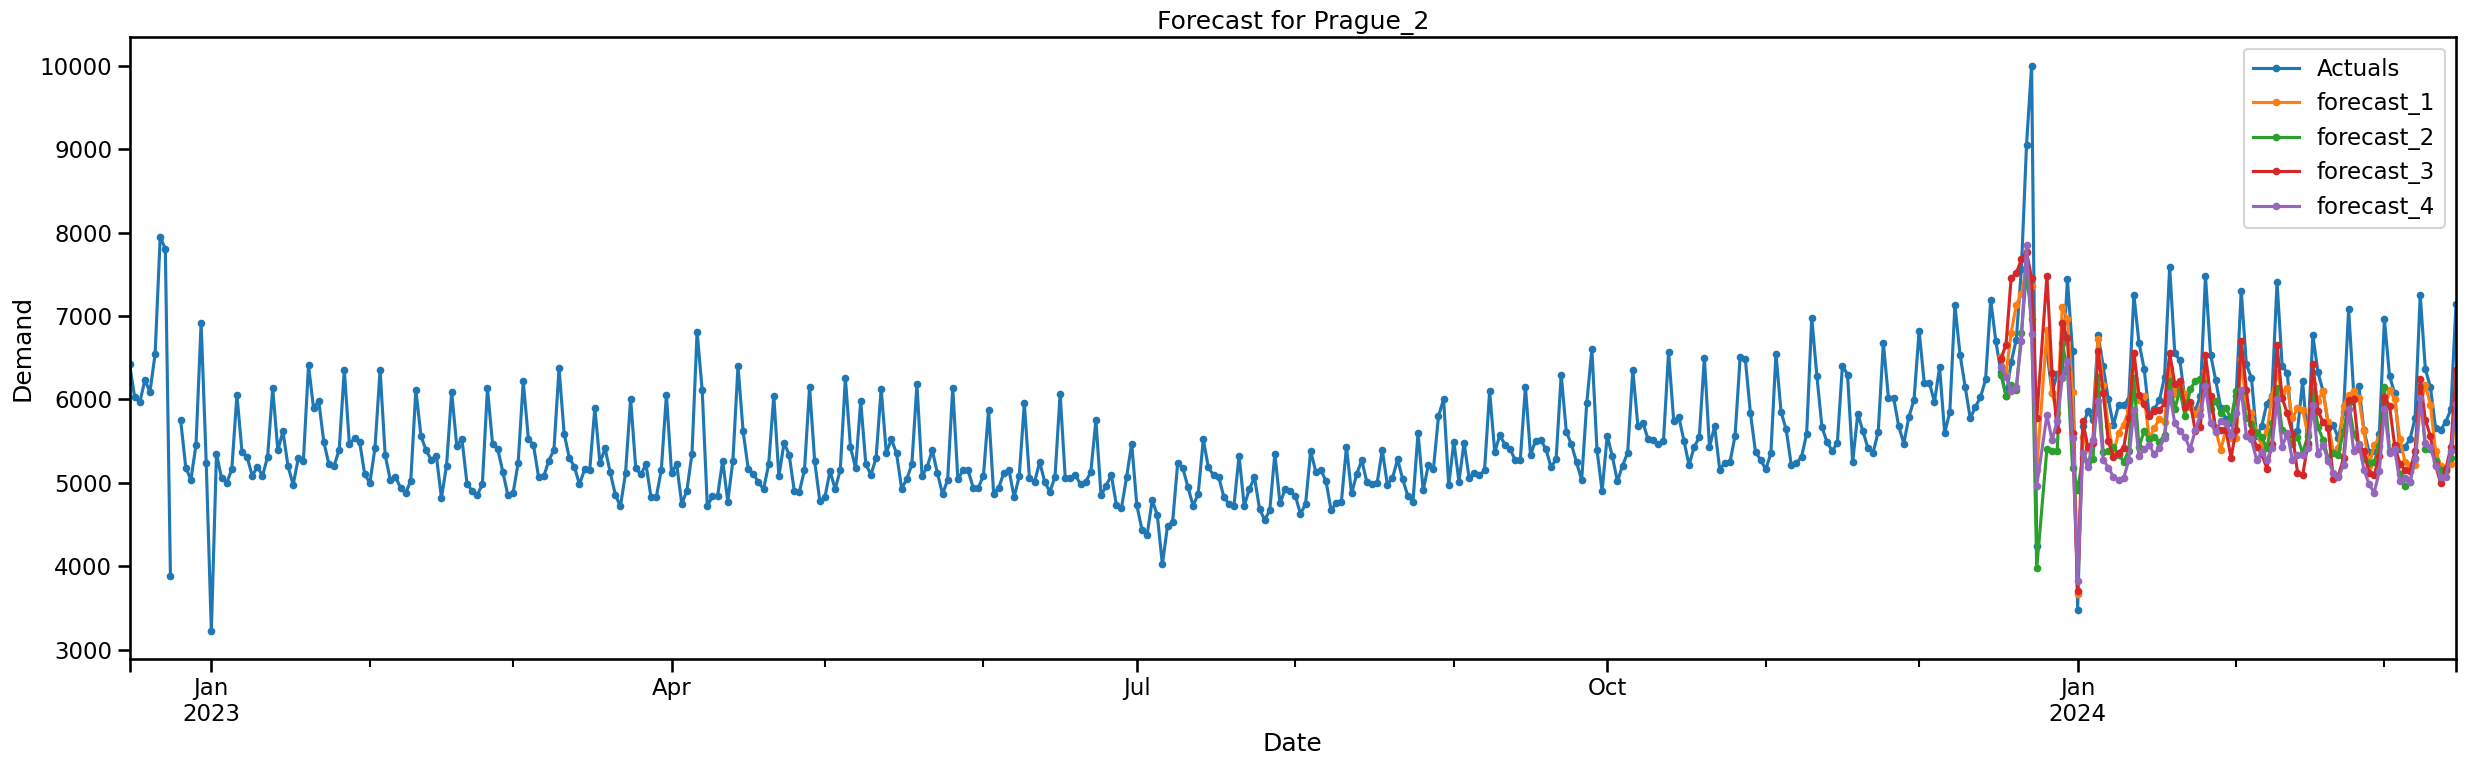

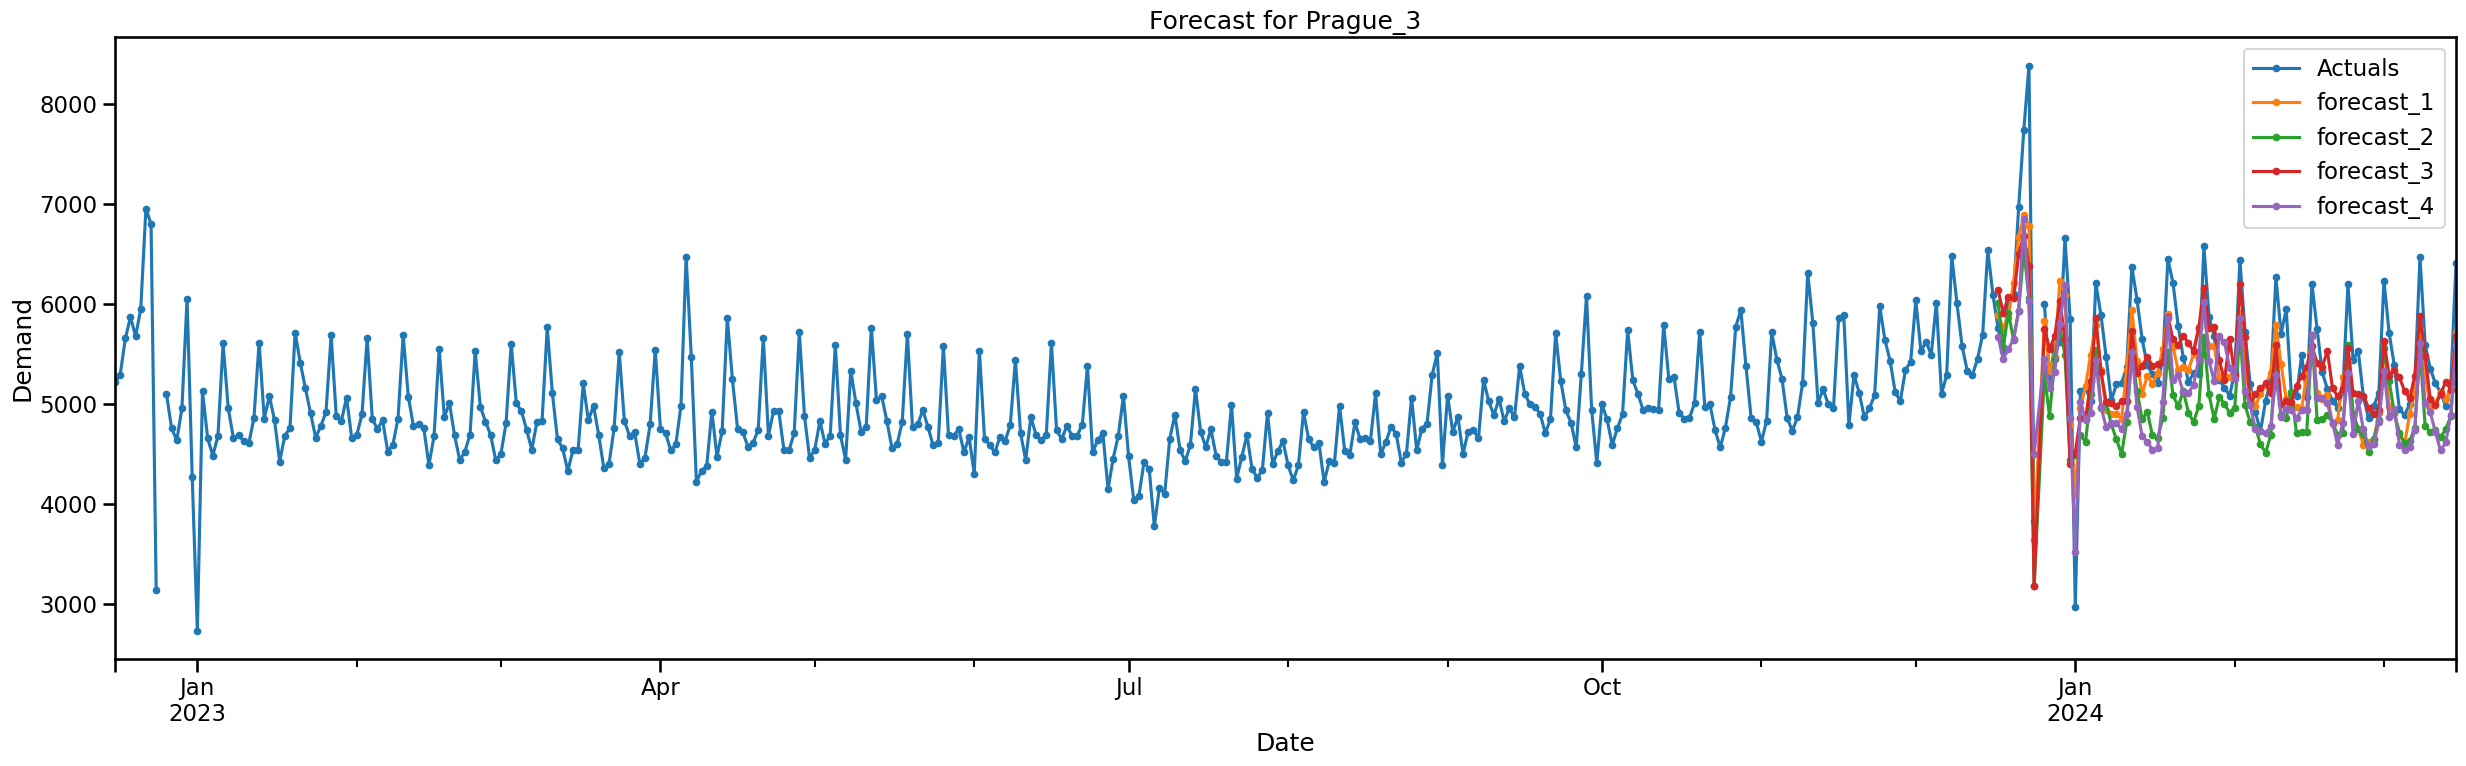

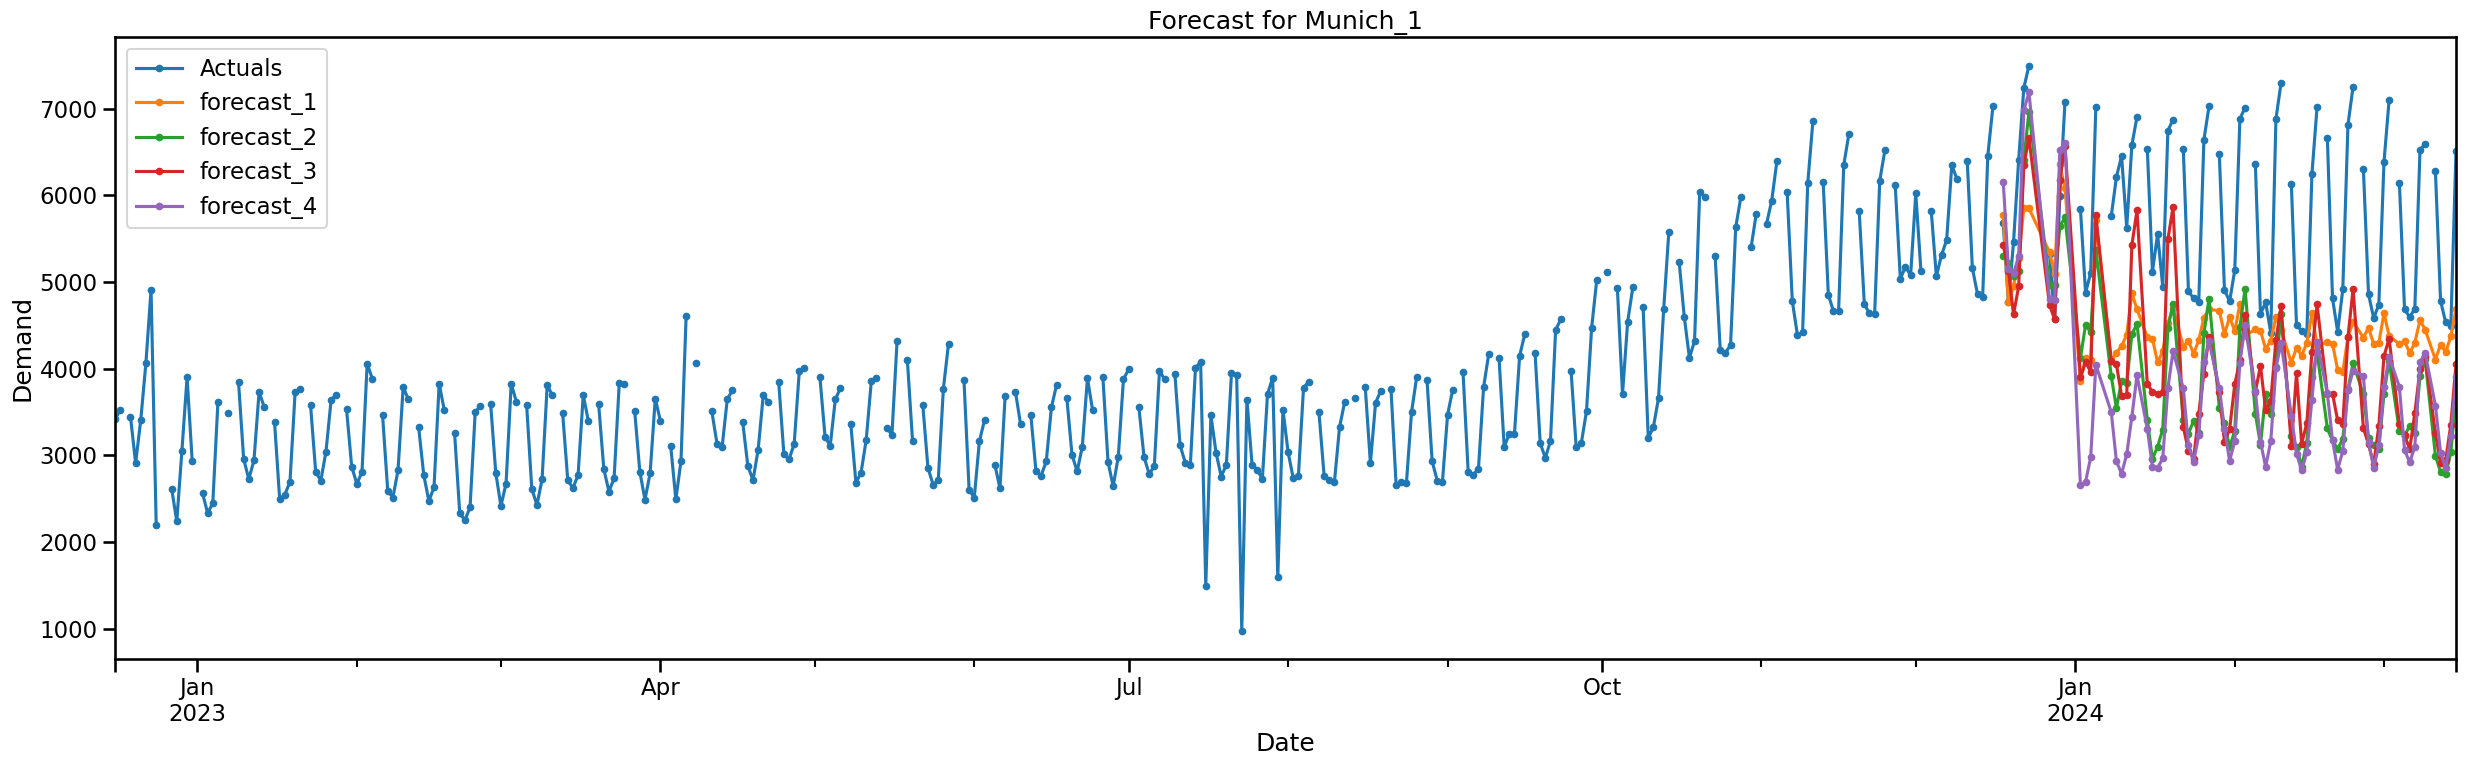

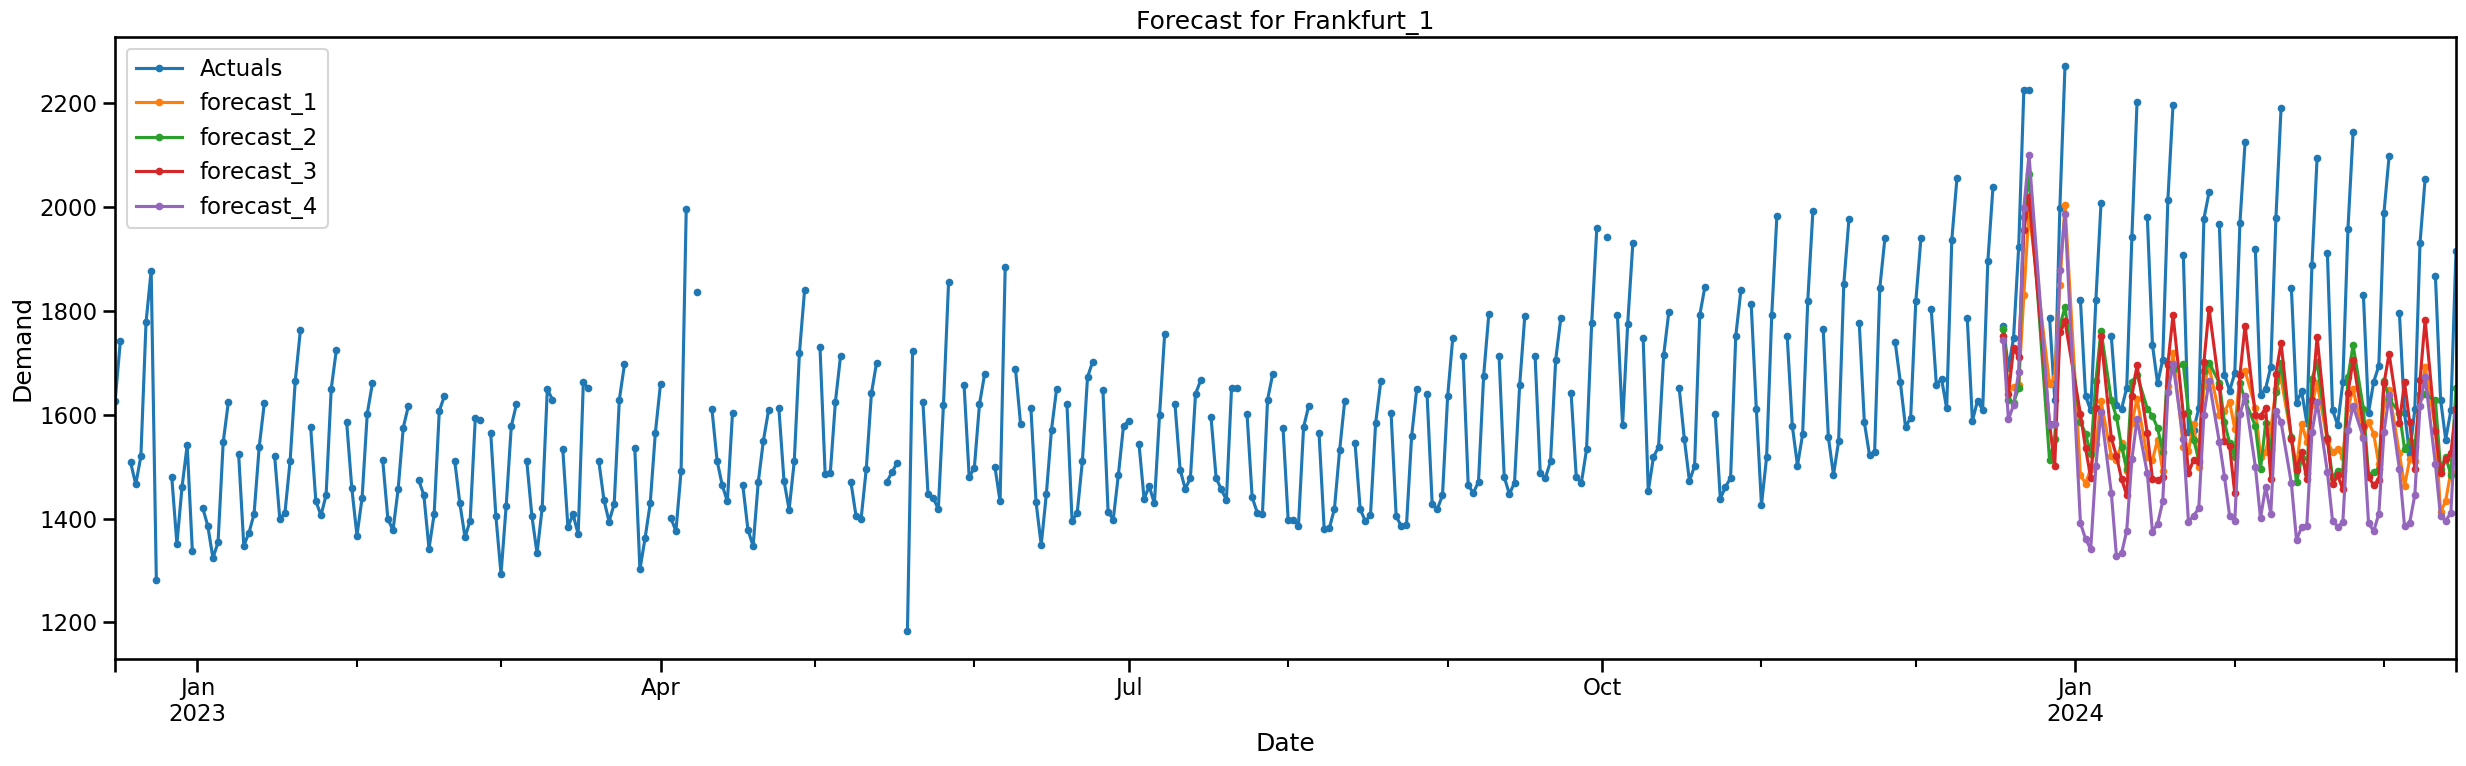

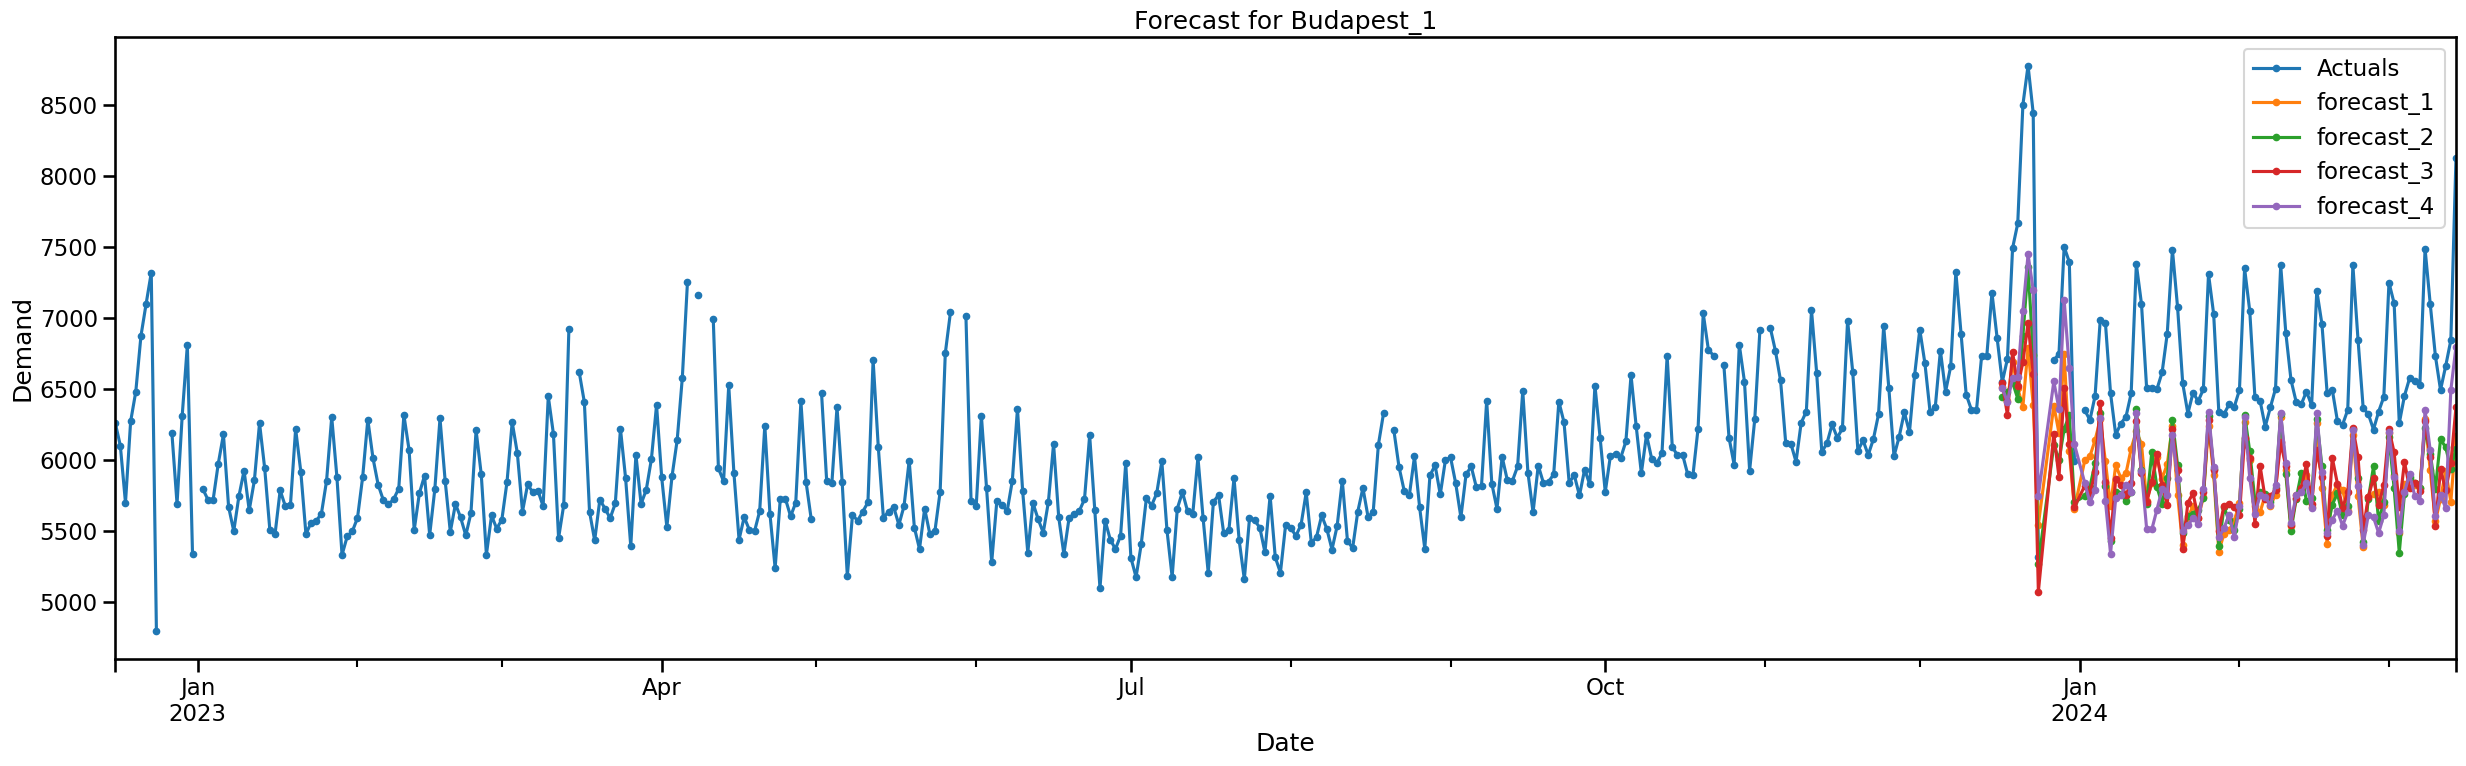

In [40]:
# warehouse= "Prague_3"
for warehouse in df.warehouse.unique():
    fig, ax = plt.subplots(figsize=[25, 7])
    min_date = df.query(
        f"split=='train' and warehouse=='{warehouse}'"
    ).index.max() - datetime.timedelta(days=365)
    # filter dates after min_date
    # df.query(f"split=='train' and warehouse=='{warehouse}'").loc[min_date:].plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df.query(f"warehouse=='{warehouse}'").loc[min_date:].plot(
        y="orders_copy", marker=".", figsize=[25, 8], legend=None, ax=ax
    )
    df_forecast.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df_forecast_2.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df_forecast_3.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="orders", marker=".", figsize=[25, 8], legend=None, ax=ax)
    df_forecast_4.query(f"split=='test' and warehouse=='{warehouse}'").set_index(
        "date"
    ).plot(y="forecast", marker=".", figsize=[25, 8], legend=None, ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Demand")
    ax.set_title("Forecast for {}".format(warehouse))
    ax.legend(["Actuals", "forecast_1", "forecast_2", "forecast_3", "forecast_4"])
    plt.tight_layout()

# final model submission


In [67]:
df = load_data()

In [68]:
df_forecast = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,

        pipeline_lags_transformer=lag_window_feats,
        imputation="mean",

    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [69]:
df_forecast_2 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=7,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_2,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [70]:
df_forecast_3 = (
    df.groupby(TRAIN_LEVEL)
    .apply(
        train_predict_sktime,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        max_lag=365,
        pipeline=pipeline,
        pipeline_lags_transformer=lag_window_feats_3,
        imputation="mean",
    )
    .drop(columns=["warehouse"])
    .reset_index()
    .query("missing==0")
)

warehouse: Brno_1
warehouse: Budapest_1
warehouse: Frankfurt_1
warehouse: Munich_1
warehouse: Prague_1
warehouse: Prague_2
warehouse: Prague_3


In [71]:
df.query(f"split=='train' and not {TARGET_COLUMNS}.isnull()").groupby(
    TRAIN_LEVEL
).apply(
    train_model_core,
    TRAIN_LEVEL,
    FEATRURE_COLUMNS,
    TARGET_COLUMNS,
    pipeline,
    model_dir=MODEL_PATH,
    include_groups=True,
).reset_index(
    drop=True
)

df_forecast_4 = (
    df.query(f"split=='test'")
    .reset_index()
    .groupby(TRAIN_LEVEL)
    .apply(
        score_model_core,
        TRAIN_LEVEL,
        FEATRURE_COLUMNS,
        TARGET_COLUMNS,
        model_dir=MODEL_PATH,
        include_groups=True,
    )
    .reset_index(drop=True)
    .query("missing==0")
)

In [73]:
df_final = (
    df_forecast[["id", "warehouse", "date", "orders"]]
    .merge(
        df_forecast_2[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_2"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_3[["id", "warehouse", "date", "orders"]].rename(
            columns={"orders": "orders_3"}
        ),
        on=["id", "warehouse", "date"],
        how="left",
    )
    .merge(
        df_forecast_4[["id", "warehouse", "date", "forecast"]],
        on=["id", "warehouse", "date"],
        how="left",
    )
)
df_final['ensemble'] = df_final[['orders', 'orders_2', 'orders_3', 'forecast']].mean(axis=1)
df_final['ensemble_2'] = df_final[['orders', 'orders_3']].mean(axis=1)

In [75]:
df_final

,id,warehouse,date,orders,orders_2,orders_3,forecast,ensemble,ensemble_2
0,Brno_1_2024-03-16,Brno_1,2024-03-16,9605.630859,9307.483398,9600.690430,9377.536133,9472.835205,9603.160645
1,Brno_1_2024-03-17,Brno_1,2024-03-17,8238.865234,8276.846680,8392.258789,8303.705078,8302.918945,8315.562012
2,Brno_1_2024-03-18,Brno_1,2024-03-18,7976.331055,8291.043945,8426.052734,8439.435547,8283.215820,8201.191895
3,Brno_1_2024-03-19,Brno_1,2024-03-19,8460.142578,8467.342773,8566.333984,8443.680664,8484.375000,8513.238281
4,Brno_1_2024-03-20,Brno_1,2024-03-20,8754.003906,8681.607422,8573.955078,8422.693359,8608.064941,8663.979492
...,...,...,...,...,...,...,...,...,...
392,Prague_3_2024-05-11,Prague_3,2024-05-11,5871.259277,5636.948242,5776.374512,5515.541016,5700.030762,5823.816895
393,Prague_3_2024-05-12,Prague_3,2024-05-12,5476.926270,5203.590820,5560.247070,5364.634766,5401.349731,5518.586670
394,Prague_3_2024-05-13,Prague_3,2024-05-13,5216.734375,4984.154785,5360.920898,5219.994141,5195.451050,5288.827637
395,Prague_3_2024-05-14,Prague_3,2024-05-14,5138.167969,4993.837402,5296.945801,5173.205566,5150.539185,5217.556885


In [77]:
PATH = "./data/submission/"
df_final.to_csv(f"{PATH}all_sumissions.csv", index=False)
df_final[["id", "orders"]].to_csv(f"{PATH}sumission_1.csv", index=False)
df_final[["id", "orders_2"]].rename(columns={"orders_2": "orders"}).to_csv(
    f"{PATH}sumission_2.csv", index=False
)
df_final[["id", "orders_3"]].rename(columns={"orders_3": "orders"}).to_csv(
    f"{PATH}sumission_3.csv", index=False
)
df_final[["id", "forecast"]].rename(columns={"forecast": "orders"}).to_csv(f"{PATH}sumission_4.csv", index=False)
df_final[["id", "ensemble"]].rename(columns={"ensemble": "orders"}).to_csv(f"{PATH}sumission_5.csv", index=False)
df_final[["id", "ensemble_2"]].rename(columns={"ensemble_2": "orders"}).to_csv(f"{PATH}sumission_6.csv", index=False)
